# Random Forest + LIBRAS

This notebook covers a Python-based solution to be compared to the experiments 1 to 4 presented in <cite data-cite="6013574/XD5B9TZQ"></cite>.

The presented solution consists in reproducing the feature vectors for each of the experiments utilizing (x, y) points in <cite data-cite="6013574/XD5B9TZQ"></cite>, applying a RandomForest classifier, and lastly, comparing the resulting performance to the ones obtained by SVM and k-NN approaches.

## Context

\# TO DO

## Dataset

\# TO DO

## Experiments

\# TO DO

In [1]:
import glob as gl
import numpy as np
from scipy.io import loadmat
from typing import List
import pandas as pd

In [2]:
def labelname(file_name):  # Extract labels from filenames 
    label = file_name.replace("data/points/sample", "").lower()
    return label.replace(".mat", "")


class Signal:  # Signal representation containing x and y coordinates and corresponding label
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

### Experiment 1

The first experiment utilizes each signal in its raw form.

In [3]:
def sigvalues(sig):  # EX.1: raw data
    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    updsig[:, ::2] = sig.x
    updsig[:, 1::2] = sig.y

    return updsig  # Updated signal

### Experiment 2

The second experiment consists of applying z-normalization to each sample. The updated coordinates are:
\begin{align}
x_{\mathcal{N(0,1)}}=\frac{x-\bar{x}}{\sigma(x)} \\
y_{\mathcal{N(0,1)}}=\frac{y-\bar{y}}{\sigma(y)}
\end{align}


In [ ]:
def sigvalues(sig):  # EX.2: z-norm
    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    for idx, x in enumerate(sig.x):
        sig.x[idx] = np.divide((np.transpose(x) - np.mean(x)), np.std(x))
    for idx, y in enumerate(sig.y):
        sig.y[idx] = np.divide((np.transpose(y) - np.mean(y)), np.std(y))

    updsig[:, ::2] = sig.x
    updsig[:, 1::2] = sig.y

    return updsig  # Updated signal

### Experiment 3

The third experiment consists of normalizing each signal by its 1st frame centroid, as follows:
\begin{align}
\tilde{x}_{P,f}=x_{P,f}-\bar{x}_{1} \\
\tilde{y}_{P,f}=y_{P,f}-\bar{y}_{1}
\end{align}

In [ ]:
def sigvalues(sig): # EX.3: norm by 1st frame centroid
    frame_x = np.split(sig.x, 5, axis=1)  # x-coordinates by frame
    frame_y = np.split(sig.y, 5, axis=1)  # y-coordinates by frame
    cent_x, cent_y = (np.mean(frame_x[0], axis=1), np.mean(frame_y[0], axis=1))  # first frame centroid of each recording

    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    for idx, x in enumerate(sig.x):
        sig.x[idx] = x - cent_x[idx]
    for idx, y in enumerate(sig.y):
        sig.y[idx] = y - cent_y[idx]

    updsig[:, ::2] = sig.x
    updsig[:, 1::2] = sig.y

    return updsig  # Updated signal

### Experiment 4

The fourth experiment consists of normalizing each signal by its current frame centroid, as follows:
\begin{align}
\tilde{x}_{P,f}=x_{P,f}-\bar{x}_{f} \\
\tilde{y}_{P,f}=y_{P,f}-\bar{y}_{f}
\end{align}

In [ ]:
def sigvalues(sig):  # EX.4
    frame_x = np.split(sig.x, 5, axis=1)  # x-coordinates by frame
    frame_y = np.split(sig.y, 5, axis=1)  # y-coordinates by frame
    cent_x, cent_y = (np.mean(frame_x, axis=2), np.mean(frame_y, axis=2))  # centroids of each recording

    nframes, nrecs, idx = np.shape(frame_x)
    updsig = np.zeros((np.shape(sig.x)[0], np.shape(sig.x)[1] * 2))
    for fx in range(nframes):
        frame_x[fx] = np.transpose(np.transpose(frame_x[fx]) - cent_x[fx])
    for fy in range(nframes):
        frame_y[fy] = np.transpose(np.transpose(frame_y[fy]) - cent_y[fy])

    updsig[:, ::2] = np.hstack(frame_x)
    updsig[:, 1::2] = np.hstack(frame_y)

    return updsig  # Updated signal

## Classification

For means of comparison, this solution utilizes the Random Forest algorithm for the classification task. Tuning is done on every iteration utilizing GridSearchCV. 

In [4]:
files = gl.glob("data/points/*.mat")  # type: list

signals = []  # type: List[Signal]

for f in files:
    data = loadmat(f).get('pontosSinal')
    signals.append(Signal(data[:, ::2], data[:, 1::2], labelname(f)))

n_signs = len(signals)
n_recs, n_x = np.shape(signals[0].x)  # Number of recordings and number of features

signals_feat = []  # Updated signals, according to each experiment
signals_labels = []
labels_dict = {}  # Dictionary of signals' labels, for reference
i = 0

for s in signals:
    signals_feat.append(sigvalues(s))
    signals_labels.append([i] * n_recs)
    labels_dict[i] = s.label
    i += 1
    
sig_features = np.reshape(signals_feat, (n_signs * n_recs, n_x * 2))
sig_labels = np.reshape(signals_labels, (n_signs * n_recs,))

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint

\# TO DO: PARAMETER SELECTION

In [6]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

\# TO DO

In [7]:
niter = 30
results = []
train_acc = []
test_acc = []
train_report =[]
class_report = []
selected_params = []
cm = [] # confusion matrix
feature_importance = []
col_names = range(1,1211)

for i in range(niter):
    print("Iteration:: ", i)
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    sss.get_n_splits(sig_features, sig_labels)

    for train_index, test_index in sss.split(sig_features, sig_labels):
        train_x, test_x = sig_features[train_index], sig_features[test_index]
        train_y, test_y = sig_labels[train_index], sig_labels[test_index]

    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                                   n_iter=100, cv=3, verbose=1, n_jobs=-1)

    rf_random.fit(train_x, train_y)
    predictions = rf_random.predict(test_x)
    
    selected_params.append(rf_random.best_params_)
    train_acc.append(accuracy_score(train_y, rf_random.predict(train_x)))
    test_acc.append(accuracy_score(test_y, predictions))
    cm.append(confusion_matrix(test_y, predictions, labels=test_y))
    class_report.append(classification_report(test_y, predictions, target_names=list(labels_dict.values())))
    feature_importance.append(pd.DataFrame(data=sorted(zip(map(lambda x: round(x, 4), 
                                                               rf_random.best_estimator_.feature_importances_), 
                                                           col_names), reverse=True)))


Iteration::  0
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  1
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  2
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


Iteration::  3
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  4
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


Iteration::  5
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


Iteration::  6
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


Iteration::  7
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.2min finished


Iteration::  8
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


Iteration::  9
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


Iteration::  10
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  11
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  12
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


Iteration::  13
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.2min finished


Iteration::  14
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


Iteration::  15
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


Iteration::  16
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  17
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration::  18
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


Iteration::  19
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


Iteration::  20
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  21
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


Iteration::  22
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.3min finished


Iteration::  23
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


Iteration::  24
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.7min finished


Iteration::  25
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.9min finished


Iteration::  26
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Iteration::  27
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.8min finished


Iteration::  28
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Iteration::  29
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished
/anaconda/envs/tensorflow/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Results

In [8]:
np.savetxt("rawtrainacc.csv",train_acc,delimiter=",")
np.savetxt("rawtestacc.csv",test_acc,delimiter=",")

In [9]:
np.savetxt('rawselected_params.txt',selected_params,fmt='%s',delimiter='\n')
np.savetxt("rawclassreport.txt",class_report,fmt='%s',delimiter='\n')

import pickle
with open('rawcm.txt', 'wb') as fp:
    pickle.dump(cm, fp)
with open('rawfeatimportance.txt', 'wb') as fp:
    pickle.dump(feature_importance, fp)

<IPython.core.display.Javascript object>


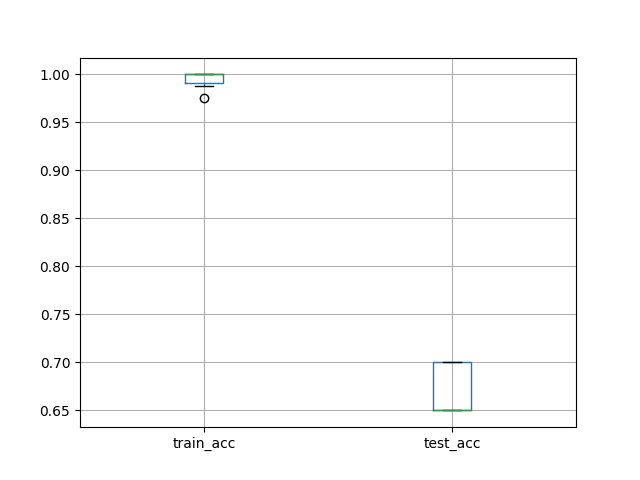

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
acc = np.transpose([train_acc, test_acc])
acc = pd.DataFrame(data=acc, columns=['train_acc', 'test_acc'])
boxplot = acc.boxplot(column=['train_acc', 'test_acc'])
plt.show()

In [12]:
acc.describe()

,train_acc,test_acc
count,30.000000,30.000000
mean,0.996250,0.666667
std,0.006687,0.023973
min,0.975000,0.650000
25%,0.990625,0.650000
50%,1.000000,0.650000
75%,1.000000,0.700000
max,1.000000,0.700000


# References

<div class="cite2c-biblio"></div>